# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [86]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dogImages/train')
valid_files, valid_targets = load_dataset('data/dogImages/valid')
test_files, test_targets = load_dataset('data/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [87]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


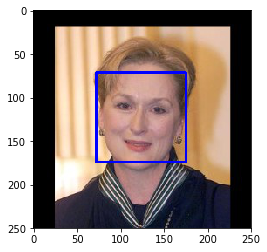

In [88]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb);
plt.show();

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [79]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [80]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def get_detected_objects(img_files, fn_to_use=face_detector):
    return len([d for d in [fn_to_use(x) for x in img_files] if d])

print("Out of {} human pics {} of them have detected human faces".format(len(human_files_short), get_detected_objects(human_files_short)))
print("Out of {} dog pics {} of them have detected human faces".format(len(dog_files_short), get_detected_objects(dog_files_short)))

Out of 100 human pics 99 of them have detected human faces
Out of 100 dog pics 12 of them have detected human faces


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

I have investigated other approaches to this issue, and **here are my findings:**

**Approach #1 Using MTCNN Package:**

There appears to be a wide variety of [deep learning implementations for face detection](https://github.com/tfygg/Deep-Learning-Papers-List/blob/master/Face.md). I tried an implementation for the MTCNN algorithm. 

https://github.com/ipazc/mtcnn

It's built for tensorflow, and packaged under pip. And its result contain a confidence estimation which I believe can be used in here.

In [81]:
# import Mtcnn and initialize detector object
from mtcnn.mtcnn import MTCNN

mtcnn_detector = MTCNN()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [82]:
# detect face from mtcnn
# installed using: pip install mtcnn

def face_detector_mtcnn(img_path):
    img = cv2.imread(img_path)
    result =  mtcnn_detector.detect_faces(img)
    
    if result:
        return result #maxþ([res['confidence'] for res in result])
    else:
        return 0
    


In [83]:
print("Out of {} human pics {} of them have detected human faces".format(len(human_files_short), get_detected_objects(human_files_short, face_detector_mtcnn)))
print("Out of {} dog pics {} of them have detected human faces".format(len(dog_files_short), get_detected_objects(dog_files_short, face_detector_mtcnn)))

Out of 100 human pics 96 of them have detected human faces
Out of 100 dog pics 15 of them have detected human faces


**Approach #2 Opencv DNN:**

I also found out that Opencv has actually implemented DNN face detector:

https://github.com/opencv/opencv/tree/master/samples/dnn/face_detector

According to [this article](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/), opencv dnn face detector has support for Caffe, TensorFlow and PyTorch (but I only found the caffe model weights). 

I believe this approach would be nice, since we are using opencv already.

In [84]:
# detect face from opencv dnn module
# note this would require opencv > 3.3
# to install simply run this: pip install opencv-contrib-python

def detect_face_dnn_opencv(img_path):
    net = cv2.dnn.readNetFromCaffe('opencv_dnn/deep-learning-face-detection/deploy.prototxt.txt', 'opencv_dnn/deep-learning-face-detection/res10_300x300_ssd_iter_140000.caffemodel')
    image = cv2.imread(img_path)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
        (300, 300), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the detections and
    # predictions
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the
    # prediction
        confidence = detections[0, 0, i, 2]
        if confidence > .5:
            return True


In [85]:
print("Out of {} human pics {} of them have detected human faces".format(len(human_files_short), get_detected_objects(human_files_short,detect_face_dnn_opencv)))
print("Out of {} dog pics {} of them have detected human faces".format(len(dog_files_short), get_detected_objects(dog_files_short,detect_face_dnn_opencv)))

Out of 100 human pics 100 of them have detected human faces
Out of 100 dog pics 54 of them have detected human faces


It seems MTCNN is more restrictive while Opencv DNN captures more faces in both human and dogs (through the confidence parameter). I believe Opencv DNN would be better used in getting the face boxes, that said, it seems there's another unsolved part of the problem, which is deciding if the image is human or dog. The next section is gonna make use of Resnet model, and the  following approach is a slight modification to try using it in this preliminary step..

**Approach #3 Using Resnet50 features to create a dog/human classifier:**


In [27]:
# get resnet features for a subset of both dog and human datasets..
def get_resnet_features_all(img_list):
    train_features = [extract_resnet(path_to_tensor(h_pic)) for h_pic in img_list]

    return np.array(train_features)

In [ ]:
# Trying on a subset from each image set..
X_train_O = get_resnet_features_all(train_files[1000:2000])
X_train_H = get_resnet_features_all(human_files[1000:2000])
# y is the training target, 0 for dogs & 1 for humans..
y = np.concatenate((np.zeros(1000),np.ones(1000)), axis=0)

In [92]:
# convert the training data to a dataframe..
import pandas as pd

X_train_All = np.concatenate((X_train_O[:,0], X_train_H[:,0]), axis=0)

feat_cols = [ 'feature'+str(i) for i in range(X_train_All.shape[1]) ]

df = pd.DataFrame(X_train_All,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (2000, 2049)


In [93]:
# get the 3 main components from the 2048
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.1742667  0.03589441 0.02967422]


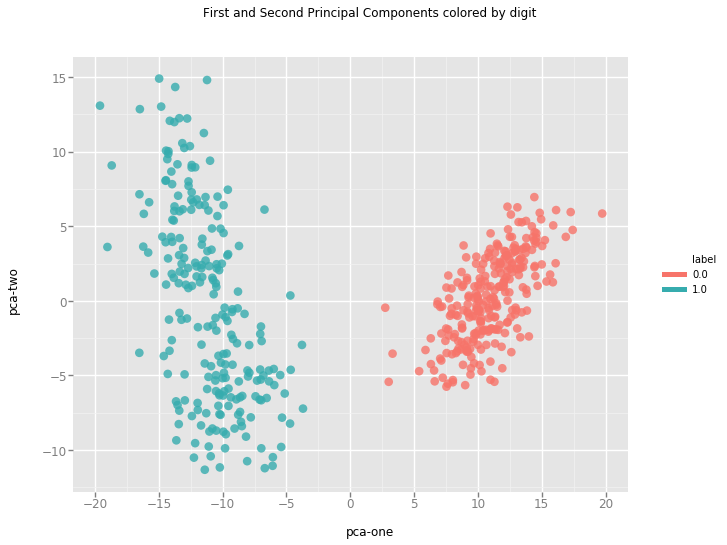

<ggplot: (8778943304021)>

In [94]:
from ggplot import *
# Ploting the first 2 components..

rndperm = np.random.permutation(df.shape[0])
chart = ggplot( df.loc[rndperm[:500],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

As we can see, only the 3 main comonenets entail about 22% of the variation. When plotting two of them, it appears the data is cleanly separated. This implies that a parametric classifier would fit them well..

In [71]:
from sklearn import svm

# get the 3 components of the train set..
X_train = pca.transform(X_train_All)

# train a svm  classifier 
clf = svm.SVC(probability=True)
clf.fit(X_train, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
from sklearn.metrics import accuracy_score

# test accuracy on the human_files_short & dog_files_short
X_test_short = np.concatenate((get_resnet_features_all(dog_files_short), get_resnet_features_all(human_files_short) , ), axis=0)
y_test_short = np.concatenate((np.zeros(len(dog_files_short)),np.ones(len(human_files_short))), axis=0)

y_pred_short = clf.predict(pca.transform(X_test_short[:,0]))

accuracy_score(y_test_short, y_pred_short)

1.0

Indeed the SMV classifier is very good at separating them. So the preliminary step of the algorithm would be passing the image through this classifier to decide if it's more similar to a dog or a human.

In [24]:
# saving/loading the classifier..
import pickle
# filename = 'saved_models/svm_mdeol.sav'
# pickle.dump(clf, open(filename, 'wb'))
# filename = 'saved_models/pca_model.sav'
# pickle.dump(pca, open(filename, 'wb'))

# load the model from disk
pca = pickle.load(open('saved_models/pca_model.sav', 'rb'))
clf = pickle.load(open('saved_models/svm_mdeol.sav', 'rb'))


### Internal reimplementation of extract_bottleneck_features  functions

This is to be used in this step and in the transfer learning step. 

In [3]:
# this is a reimplementation of extract_bottleneck_features.py file 
# with avg pooling and global models for reuse..

from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

resnet_model = ResNet50(input_shape=(224, 224, 3), pooling="avg" , weights='imagenet',  include_top=False) #,pooling="avg"  #  # Since top layer is the fc layer used for predictions
inception_model = InceptionV3(input_shape=(224, 224, 3), pooling="avg" , weights='imagenet',  include_top=False)
xception_model = Xception(input_shape=(224, 224, 3), pooling="avg" , weights='imagenet',  include_top=False)

def extract_resnet(X, generator=None):  
    from keras.applications.resnet50 import preprocess_input
    
    features_array = resnet_model.predict(preprocess_input(X))
    return features_array

def extract_inception(X):  
    from keras.applications.inception_v3 import preprocess_input
    
    features_array = inception_model.predict(preprocess_input(X))
    return features_array

def extract_xception(X):  
    from keras.applications.xception import preprocess_input
    
    features_array = xception_model.predict(preprocess_input(X))
    return features_array

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [ ]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [20]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile, Image                           
ImageFile.LOAD_TRUNCATED_IMAGES = True           

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [119]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [118]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [120]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

print("Out of {} human pics {} of them have detected dogs".format(len(human_files_short), get_detected_objects(human_files_short,dog_detector)))
print("Out of {} dog pics {} of them have detected dogs".format(len(dog_files_short), get_detected_objects(dog_files_short,dog_detector)))

Out of 100 human pics 0 of them have detected dogs
Out of 100 dog pics 100 of them have detected dogs


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile, Image                           
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I used the suggested architecture as a starting point, and modified the conv2d filter number and added additional layer with 256 filter. Also added additional dense layer before the final one. I believe CNN architecture is great for image classification because it takes into account context of the data (surrounding pixels of each pixel) in addition to the hierarchal nature of images (from primitive features to high level ones). That's why a deep CNN with enough many layers would be great in classifying down pictures.

In [99]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=265, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 64)        0         
__________

### Compile the Model

In [101]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [106]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 27s 4ms/step - loss: 3.6926 - acc: 0.1403 - val_loss: 4.0060 - val_acc: 0.0934

Epoch 00001: val_loss improved from inf to 4.00603, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/5
6680/6680 [==============================] - 27s 4ms/step - loss: 3.4569 - acc: 0.1774 - val_loss: 3.8524 - val_acc: 0.1078

Epoch 00002: val_loss improved from 4.00603 to 3.85243, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/5
6680/6680 [==============================] - 27s 4ms/step - loss: 3.2271 - acc: 0.2171 - val_loss: 3.9642 - val_acc: 0.1269

Epoch 00003: val_loss did not improve from 3.85243
Epoch 4/5
6680/6680 [==============================] - 27s 4ms/step - loss: 2.9895 - acc: 0.2681 - val_loss: 3.9646 - val_acc: 0.1018

Epoch 00004: val_loss did not improve from 3.85243
Epoch 5/5
6680/6680 [==============================] - 27s 4ms/step - loss: 2.7159 

### Load the Model with the Best Validation Loss

In [107]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [108]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.1244%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [109]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [110]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [111]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [112]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 399us/step - loss: 11.9237 - acc: 0.1280 - val_loss: 10.1901 - val_acc: 0.2383

Epoch 00001: val_loss improved from inf to 10.19012, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 192us/step - loss: 9.3490 - acc: 0.3193 - val_loss: 9.4104 - val_acc: 0.3054

Epoch 00002: val_loss improved from 10.19012 to 9.41037, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 192us/step - loss: 8.7383 - acc: 0.3865 - val_loss: 8.9483 - val_acc: 0.3605

Epoch 00003: val_loss improved from 9.41037 to 8.94834, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 191us/step - loss: 8.4412 - acc: 0.4289 - val_loss: 8.8873 - val_acc: 0.3581

Epoch 00004: val_loss improved from 8.94834 to 8.88733, saving model to saved_

### Load the Model with the Best Validation Loss

In [113]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [114]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.7608%


### Predict Dog Breed with the Model

In [115]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']


Since it's not computationally expensive, I sought attempting more than one of the pre-trained available CNNs. The idea is to compare each of their performance and potentially explore if combining them all would enhance the overall predication.
However, after downloading the pre-computed features I found they needed global average pooling in order to have a (N, 2048) tensor for each. This is done in the reimplementation of bottleneck_features.py above..

In [5]:
# also, in order to have exact bottleneck features to the pre-computed ones, I needed to remove dividing the images by 255 
train_tensors_a = paths_to_tensor(train_files).astype('float32')
valid_tensors_a = paths_to_tensor(valid_files).astype('float32')
test_tensors_a = paths_to_tensor(test_files).astype('float32')

100%|██████████| 836/836 [00:12<00:00, 67.11it/s]


In [6]:
# saving bottleneck_featres with avg_pooling for the images..
def save_bottleneck_featres_with_avg_pooling(fn_to_use):
    bottlneck_features_train = fn_to_use(train_tensors_a)
    bottlneck_features_valid = fn_to_use(valid_tensors_a)
    bottlneck_features_test = fn_to_use(test_tensors_a)
    np.savez('bottleneck_features/%s.npz'% fn_to_use.__name__, train=bottlneck_features_train, valid=bottlneck_features_valid, test=bottlneck_features_test)

# save_bottleneck_featres_with_avg_pooling(extract_resnet)
# save_bottleneck_featres_with_avg_pooling(extract_inception)
# save_bottleneck_featres_with_avg_pooling(extract_xception)

In [7]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
def load_bottleneck_featres_with_avg_pooling(fn_to_use):
    bottleneck_features = np.load('bottleneck_features/%s.npz'%fn_to_use.__name__)

    return bottleneck_features['train'], bottleneck_features['valid'], bottleneck_features['test']

train_Resnet50, valid_Resnet50, test_Resnet50 = load_bottleneck_featres_with_avg_pooling(extract_resnet)
train_Xception, valid_Xception, test_Xception = load_bottleneck_featres_with_avg_pooling(extract_xception)
train_Inception, valid_Inception, test_Inception = load_bottleneck_featres_with_avg_pooling(extract_inception)

In [134]:
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD

# This function combines defining/training/testing the model, to ease comparing the different pre-trained networds..
def train_test_tl_model(base_model, train_data, train_target_data, valid_data, valid_targets, test_data, test_targets_data):
    ### TODO: Define your architecture.
    TL_model = Sequential()
    TL_model.add(Dense(133,input_shape=train_data.shape[1:],  activation='softmax'))
    
    ### TODO: Compile the model.
    TL_model.compile(loss='categorical_crossentropy', optimizer='adamx', metrics=['accuracy'])

    ### TODO: Load the model weights with the best validation loss.
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.%s.hdf5'% base_model, 
                                   verbose=0, save_best_only=True)
    
    print("Training for base model: {}".format(base_model))
    TL_model.fit(train_data, train_target_data, 
              validation_data=(valid_data, valid_targets),
              epochs=5, batch_size=100, callbacks=[checkpointer], verbose=1)

    ### TODO: Load the model weights with the best validation loss.
    TL_model.load_weights('saved_models/weights.best.%s.hdf5'%base_model)


    # get index of predicted dog breed for each image in test set
    TL_predictions = [np.argmax(TL_model.predict(np.expand_dims(feature, axis=0))) for feature in test_data]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(TL_predictions)==np.argmax(test_targets_data, axis=1))/len(TL_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)

In [42]:
train_test_tl_model("Resnet50", train_Resnet50, train_targets, valid_Resnet50, valid_targets, test_Resnet50, test_targets)
train_test_tl_model("Xception", train_Xception, train_targets, valid_Xception, valid_targets, test_Xception, test_targets)
train_test_tl_model("Inception", train_Inception, train_targets, valid_Inceptioan, valid_targets, test_Inception, test_targets)

Training for base model: Resnet50
Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 3s 455us/step - loss: 2.5586 - acc: 0.4521 - val_loss: 1.3401 - val_acc: 0.6826
Epoch 2/5
6680/6680 [==============================] - 0s 45us/step - loss: 0.8409 - acc: 0.8272 - val_loss: 0.9602 - val_acc: 0.7605
Epoch 3/5
6680/6680 [==============================] - 0s 44us/step - loss: 0.5545 - acc: 0.8963 - val_loss: 0.8110 - val_acc: 0.7844
Epoch 4/5
6680/6680 [==============================] - 0s 45us/step - loss: 0.4097 - acc: 0.9358 - val_loss: 0.7361 - val_acc: 0.7940
Epoch 5/5
6680/6680 [==============================] - 0s 44us/step - loss: 0.3216 - acc: 0.9567 - val_loss: 0.7036 - val_acc: 0.7892
Test accuracy: 80.8612%
Training for base model: Xception
Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 3s 459us/step - loss: 1.8429 - acc: 0.6295 - val_loss: 0.7662 - val_acc: 0.8299
Epoch 2/

It seems the 3 CNNs attempted are close in their accuracy. From best to worst:
- Xception
- Inception
- Resnet50

Now will try to combine them together as one feature tensor with (N, 2048 x 3) shape.

In [8]:
train_Combined = np.concatenate((train_Resnet50, train_Xception, train_Inception), axis=1)
valid_Combined = np.concatenate((valid_Resnet50, valid_Xception, valid_Inception), axis=1)
test_Combined = np.concatenate((test_Resnet50, test_Xception, test_Inception), axis=1)

In [43]:
# get them all combined
train_Combined = np.concatenate((train_Resnet50, train_Xception, train_Inception), axis=1)
valid_Combined = np.concatenate((valid_Resnet50, valid_Xception, valid_Inception), axis=1)
test_Combined = np.concatenate((test_Resnet50, test_Xception, test_Inception), axis=1)
train_test_tl_model("Combined", train_Combined, train_targets, valid_Combined, valid_targets, test_Combined, test_targets)

Training for base model: Combined
Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 3s 390us/step - loss: 1.8470 - acc: 0.6121 - val_loss: 0.6624 - val_acc: 0.8299
Epoch 2/5
6680/6680 [==============================] - 0s 60us/step - loss: 0.4588 - acc: 0.8810 - val_loss: 0.4918 - val_acc: 0.8731
Epoch 3/5
6680/6680 [==============================] - 0s 60us/step - loss: 0.3071 - acc: 0.9253 - val_loss: 0.4362 - val_acc: 0.8731
Epoch 4/5
6680/6680 [==============================] - 0s 62us/step - loss: 0.2361 - acc: 0.9500 - val_loss: 0.4245 - val_acc: 0.8838
Epoch 5/5
6680/6680 [==============================] - 0s 64us/step - loss: 0.1890 - acc: 0.9612 - val_loss: 0.3975 - val_acc: 0.8874
Test accuracy: 88.2775%


Indeed combining them together got the best result. And it also nearly took the same time to train.  

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
 I chose the same architecture of the former VGG16 model, because it's very fast and adding additional dense layers didn't improve the result. The input of the network is combined from 3 of the pretrained networks as outlined above.


In [65]:
# Just restating the results above for reuse..
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
### TODO: Define your architecture.
Combined_model = Sequential()
# lazem
Combined_model.add(Dense(133,input_shape=train_Combined.shape[1:],  activation='softmax'))
Combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 133)               817285    
Total params: 817,285
Trainable params: 817,285
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [69]:
from keras.optimizers import SGD
### TODO: Compile the model.
# optimizer is chosen by grid search underlined in appendix below
Combined_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [72]:
from keras.callbacks import ModelCheckpoint  
import time
### TODO: Load the model weights with the best validation loss.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Combined.hdf5', 
                               verbose=1, save_best_only=True)

Combined_model.fit(train_Combined, train_targets, 
          validation_data=(valid_Combined, valid_targets),
          epochs=5, batch_size=100, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 0s 42us/step - loss: 0.0197 - acc: 0.9976 - val_loss: 0.3486 - val_acc: 0.8946

Epoch 00001: val_loss improved from inf to 0.34858, saving model to saved_models/weights.best.Combined.hdf5
Epoch 2/5
6680/6680 [==============================] - 0s 42us/step - loss: 0.0136 - acc: 0.9988 - val_loss: 0.3493 - val_acc: 0.8970

Epoch 00002: val_loss did not improve from 0.34858
Epoch 3/5
6680/6680 [==============================] - 0s 41us/step - loss: 0.0131 - acc: 0.9987 - val_loss: 0.3492 - val_acc: 0.8958

Epoch 00003: val_loss did not improve from 0.34858
Epoch 4/5
6680/6680 [==============================] - 0s 41us/step - loss: 0.0126 - acc: 0.9988 - val_loss: 0.3499 - val_acc: 0.8982

Epoch 00004: val_loss did not improve from 0.34858
Epoch 5/5
6680/6680 [==============================] - 0s 42us/step - loss: 0.0122 - acc: 0.9988 - val_loss: 0.3505 - val_acc: 0.8970

Epoch 00005: val_

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [66]:
### TODO: Load the model weights with the best validation loss.
Combined_model.load_weights('saved_models/weights.best.Combined_Saved.hdf5')	

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [73]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Combined_predictions = [np.argmax(Combined_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Combined]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Combined_predictions)==np.argmax(test_targets, axis=1))/len(Combined_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)	  

Test accuracy: 88.5167%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [18]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def combined_models_predict_breed(img_path):
    
    tensor_img = path_to_tensor(img_path)
    # extract bottleneck features of the 3 CNNs
    bottleneck_feature_x = extract_xception(tensor_img)
    bottleneck_feature_i = extract_inception(tensor_img)
    bottleneck_feature_r = extract_resnet(tensor_img)
    # combine them and use as an input for final model predictiton
    bottleneck_feature = np.concatenate((bottleneck_feature_r, bottleneck_feature_x, bottleneck_feature_i,), axis=1)
    predicted_vector = Combined_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


# Attempt using Image Generator

The following is an attempt to use keras's Image Generator to enhance the final model results. I have faced multiple issues because I needed to use the generator on the pre-trained CNNs first before feeding the results to the final model. Eventually to be able to retest I opted to save the generated images first.

First I fitted two generators, one with these paramers:
*rotation_range=10,
width_shift_range=.1,
height_shift_range=.1,*

And the other with  *horizontal_flip=True*

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(

    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
#     preprocessing_function=preprocess_input,
#     horizontal_flip=True,

)
image_gen.fit(train_tensors_a, augment=True,)

In [ ]:

# generate the images and save them into two directories..
batch_size = 10
i=0
batches = 0
for img_batch in image_gen.flow(train_tensors_a, shuffle=False, batch_size=batch_size, save_to_dir='data/dogImages/aug2/', save_format="jpeg"):
    batches += 1
    if batches >= len(train_tensors_a) / 10:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

In [5]:
# get the augumented images by order of their creation..
import os
from pathlib import Path

train_files_aug = sorted(Path('data/dogImages/aug/').iterdir(), key=lambda f: f.stat().st_mtime)
train_files_aug = [str(x) for x in train_files_aug if '.jpeg' in x.name]
# data
len(train_files_aug)

6680

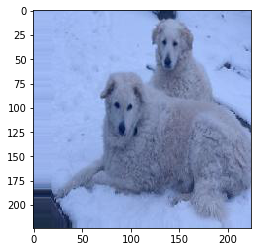

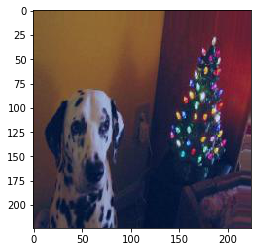

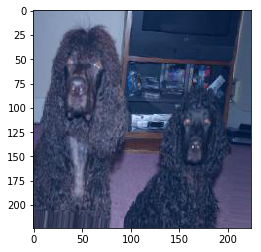

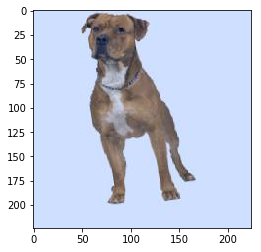

In [4]:
# Display the image
for img_path in train_files_aug[:4]:
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

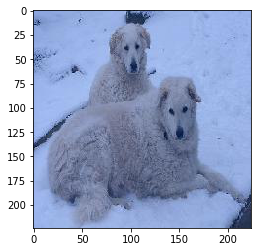

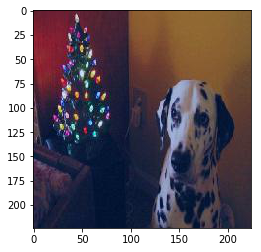

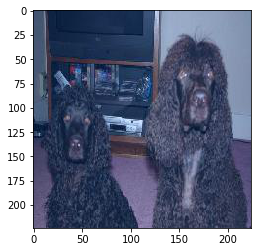

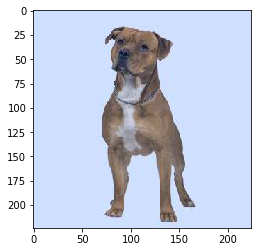

In [6]:
# Display the images
for img_path in train_files_aug[:4]:
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [6]:
from PIL import ImageFile, Image                           
ImageFile.LOAD_TRUNCATED_IMAGES = True
# convert aumgumented images to tensor
train_tensors_aug = paths_to_tensor(train_files_aug).astype('float32')

100%|██████████| 6680/6680 [00:15<00:00, 433.26it/s]


In [ ]:
def save_bottleneck_featres_with_avg_pooling_aug(fn_to_use):
    bottlneck_features_train = fn_to_use(train_tensors_aug)
#     bottlneck_features_valid = fn_to_use(valid_tensors_a)
#     bottlneck_features_test = fn_to_use(test_tensors_a)
    np.savez('bottleneck_features/%s_aug.npz'% fn_to_use.__name__, train=bottlneck_features_train, )#valid=bottlneck_features_valid, test=bottlneck_features_test)

# save bottlneck features with avg pooling..    
save_bottleneck_featres_with_avg_pooling_aug(extract_resnet)
save_bottleneck_featres_with_avg_pooling_aug(extract_inception)
save_bottleneck_featres_with_avg_pooling_aug(extract_xception)

In [12]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
def load_bottleneck_featres_with_avg_pooling_aug(fn_to_use):
    bottleneck_features = np.load('bottleneck_features/%s_aug.npz'%fn_to_use.__name__)

    return bottleneck_features['train']#, bottleneck_features['valid'], bottleneck_features['test']

train_Resnet50_aug = load_bottleneck_featres_with_avg_pooling_aug(extract_resnet) #valid_Resnet50, test_Resnet50 
train_Xception_aug = load_bottleneck_featres_with_avg_pooling_aug(extract_xception) #, valid_Xception, test_Xception
train_Inception_aug = load_bottleneck_featres_with_avg_pooling_aug(extract_inception) #, valid_Inception, test_Inception

# after loading, combine both original and augumented pics features 
train_Augumented_targets = np.concatenate((train_targets, train_targets, train_targets), axis=0)
train_Xception_all = np.concatenate((train_Xception, train_Xception_aug), axis=0)
train_Inception_all = np.concatenate((train_Inception, train_Inception_aug), axis=0)
train_Resnet50_all = np.concatenate((train_Resnet50, train_Resnet50_aug), axis=0)


In [21]:
# test augumented models..
train_test_tl_model("Augumented-Xception", train_Xception_all, train_Augumented_targets, valid_Xception, valid_targets, test_Xception, test_targets)
train_test_tl_model("Augumented-Inception", train_Inception_all, train_Augumented_targets, valid_Inception, valid_targets, test_Inception, test_targets)
train_test_tl_model("Augumented-Resnet50", train_Resnet50_all, train_Augumented_targets, valid_Resnet50, valid_targets, test_Resnet50, test_targets)

Training for base model: Augumented-Xception
Train on 20040 samples, validate on 835 samples
Epoch 1/5
20040/20040 [==============================] - 3s 154us/step - loss: 2.9304 - acc: 0.5121 - val_loss: 1.3955 - val_acc: 0.7557
Epoch 2/5
20040/20040 [==============================] - 1s 38us/step - loss: 1.5298 - acc: 0.7360 - val_loss: 0.8968 - val_acc: 0.8120
Epoch 3/5
20040/20040 [==============================] - 1s 39us/step - loss: 1.3157 - acc: 0.7709 - val_loss: 0.7523 - val_acc: 0.8335
Epoch 4/5
20040/20040 [==============================] - 1s 38us/step - loss: 1.2334 - acc: 0.7854 - val_loss: 0.6904 - val_acc: 0.8359
Epoch 5/5
20040/20040 [==============================] - 1s 38us/step - loss: 1.1828 - acc: 0.7944 - val_loss: 0.6483 - val_acc: 0.8443
Test accuracy: 84.2105%
Training for base model: Augumented-Inception
Train on 20040 samples, validate on 835 samples
Epoch 1/5
20040/20040 [==============================] - 3s 155us/step - loss: 2.0102 - acc: 0.6170 - val_lo

In [15]:
# now get them all combined
train_Combined_all = np.concatenate((train_Resnet50_all, train_Xception_all, train_Inception_all), axis=1)
valid_Combined = np.concatenate((valid_Resnet50, valid_Xception, valid_Inception), axis=1)
test_Combined = np.concatenate((test_Resnet50, test_Xception, test_Inception), axis=1)
train_test_tl_model("Augumented-Combined", train_Combined_all, train_Augumented_targets, valid_Combined, valid_targets, test_Combined, test_targets)

Training for base model: Augumented-Combined
Train on 20040 samples, validate on 835 samples
Epoch 1/5
20040/20040 [==============================] - 4s 176us/step - loss: 1.5017 - acc: 0.7374 - val_loss: 0.5319 - val_acc: 0.8563
Epoch 2/5
20040/20040 [==============================] - 1s 59us/step - loss: 0.8584 - acc: 0.8691 - val_loss: 0.5392 - val_acc: 0.8527
Epoch 3/5
20040/20040 [==============================] - 1s 59us/step - loss: 0.6831 - acc: 0.8924 - val_loss: 0.4964 - val_acc: 0.8731
Epoch 4/5
20040/20040 [==============================] - 1s 59us/step - loss: 0.5498 - acc: 0.9034 - val_loss: 0.5098 - val_acc: 0.8563
Epoch 5/5
20040/20040 [==============================] - 1s 59us/step - loss: 0.4538 - acc: 0.9117 - val_loss: 0.5470 - val_acc: 0.8539
Test accuracy: 87.0813%


As we can see, there's slight to no improvement in the performance using the augumented features, when used alone without the original images, there was actually decline in performance. 

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [25]:
import re

# use resnet and svm classifier to decide on human or dog
# can get probablity to discard on threshold (neither)
def detect_human_or_dog(img_path):
    img_ts = get_resnet_features_all([img_path])
    result = clf.predict(pca.transform(img_ts[:,0]))
    if result:
        return result

def show_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb);
    plt.show();

# main function showing decision sentence
def detect_dog_sim_breed(img_path):
    # detect first if human or dog
    is_human = detect_human_or_dog(img_path)
    if is_human:
        is_human = 'human'
    else:
        is_human = 'dog'
    # then predict breed
    breed = combined_models_predict_breed(img_path)
    # show prediction
    print('You look like a {} and your predicted breed is {}.'.format(is_human, re.sub(r'\/\d+\.(:?.*)$',r'\1',breed)))
    show_img(img_path)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

I ran the model on several images of different types, and I believe it gets the breeds well when the images are close to the ones in the dataset, otherwise the predications are not so accurate, but the predicted breeds share some similarity to the correct predictions. 

You look like a dog and your predicted breed is Cavalier_king_charles_spaniel.


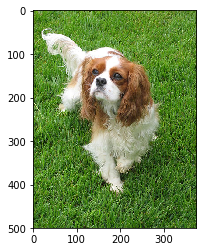

You look like a dog and your predicted breed is Kuvasz.


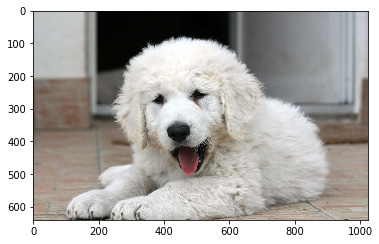

You look like a dog and your predicted breed is Bulldog.


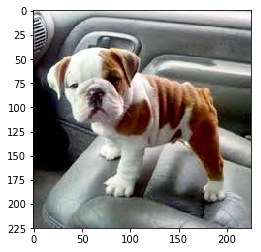

You look like a dog and your predicted breed is French_bulldog.


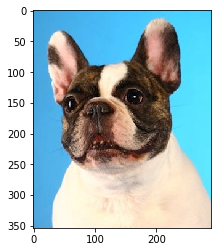

You look like a dog and your predicted breed is Icelandic_sheepdog.


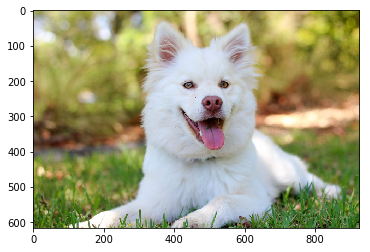

In [74]:
test_iamges = ['cavalier_king_charles_spanie.jpg', 'kuvasz.jpg', 'bulldog.jpg', 'unknown1.jpg',  'unknown2.jpeg']
for test_image in test_iamges:
    detect_dog_sim_breed('test_files/'+test_image)

I ran it over some human pics (mine got Bearded_collie), and also tried to see if some of [these celebreties](http://themindcircle.com/22-animals-that-totally-look-like-celebrities/) do look like dogs compared to them!

You look like a dog and your predicted breed is Bearded_collie.


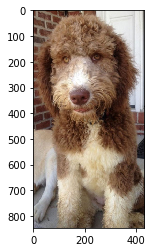

You look like a human and your predicted breed is Bearded_collie.


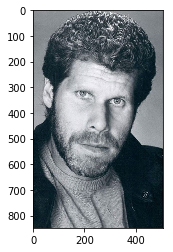

You look like a dog and your predicted breed is Xoloitzcuintli.


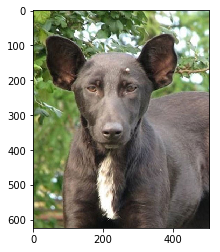

You look like a human and your predicted breed is Chinese_crested.


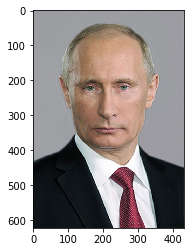

In [75]:
test_iamges = ['pldog.jpg', 'perlman.jpg', 'pdog.jpg', 'putin.jpg', ]
for test_image in test_iamges:
    detect_dog_sim_breed('test_files/'+test_image)

Also ran on some other animals..

You look like a dog and your predicted breed is Icelandic_sheepdog.


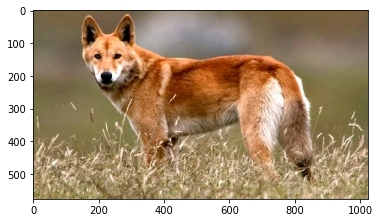

You look like a dog and your predicted breed is Chinese_shar-pei.


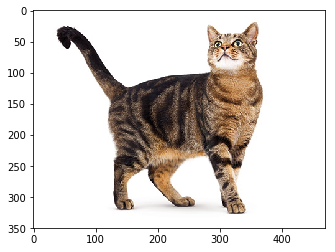

You look like a dog and your predicted breed is Bearded_collie.


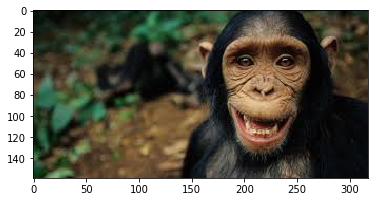

In [76]:
test_iamges = ['dingo.jpg', 'cat.jpg', 'chimp.jpg', ]
for test_image in test_iamges:
    detect_dog_sim_breed('test_files/'+test_image)


In conclusion, I believe the transfer learning method is very helpful to get decent results in spite of having rather small dataset. And I think the following points would improve the algorithm:
- Include more data: Most important factor in my opinion, if we have a much bigger dataset with sizable amount per breed, the algorithm accuracy will be better and more generalized.
- Improve data augmentation: I thought this would make noticeable enhancement and I think it needs more investigation on why it wasn't useful in enhancing the results (Are more generated images needed?). 
- Was also thinking of adding a cool feature of morphing the human face to its most similar dog (something like the one below but this is done manually). The algorithm would check the closest distance to the breed images then get the face landmarks for both the human and the dog pictures, and merge both [to get a morphed one.](https://www.learnopencv.com/face-morph-using-opencv-cpp-python/)

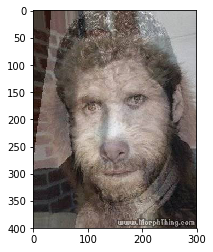

In [84]:
show_img('./test_files/morph.jpeg')

## Appendix: Fine Tuning Hyper-Parameters using Grid Search

Using [sklearn GridSearchCV](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/), I have tried to fine tune optimizer, #epochs, #batches and learning rate used the resutls in the final model above.


In [20]:
# learning rate and momentum
from keras.optimizers import SGD
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
    # create model
    TL_model = Sequential()
    TL_model.add(Dense(133,input_shape=train_valid_Combined.shape[1:],  activation='softmax'))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    ### TODO: Compile the model.
    TL_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return TL_model

In [21]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=1, epochs=20, batch_size=40, )
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_valid_Combined, train_valid_target_Combined,)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
5010/5010 [==============================] - 3s 578us/step - loss: 4.8223 - acc: 0.0359
Epoch 2/20
5010/5010 [==============================] - 0s 98us/step - loss: 4.0374 - acc: 0.2040
Epoch 3/20
5010/5010 [==============================] - 0s 98us/step - loss: 3.3894 - acc: 0.3956
Epoch 4/20
5010/5010 [==============================] - 0s 97us/step - loss: 2.8486 - acc: 0.5333
Epoch 5/20
5010/5010 [==============================] - 0s 98us/step - loss: 2.4074 - acc: 0.6226
Epoch 6/20
5010/5010 [==============================] - 0s 97us/step - loss: 2.0566 - acc: 0.6723
Epoch 7/20
5010/5010 [==============================] - 0s 98us/step - loss: 1.7794 - acc: 0.7144
Epoch 8/20
5010/5010 [==============================] - 0s 97us/step - loss: 1.5613 - acc: 0.7495
Epoch 9/20
5010/5010 [==============================] - 0s 97us/step - loss: 1.3883 - acc: 0.7689
Epoch 10/20
5010/5010 [==============================] - 0s 98us/step - loss: 1.2490 - acc: 0.7888
Epoch 11/20
5010/5

5010/5010 [==============================] - 0s 98us/step - loss: 0.4754 - acc: 0.9168
Epoch 19/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.4546 - acc: 0.9212
Epoch 20/20
5010/5010 [==============================] - 0s 66us/step
Epoch 1/20
5010/5010 [==============================] - 3s 603us/step - loss: 4.6468 - acc: 0.0585
Epoch 2/20
5010/5010 [==============================] - 0s 99us/step - loss: 3.4833 - acc: 0.3401
Epoch 3/20
5010/5010 [==============================] - 0s 98us/step - loss: 2.6171 - acc: 0.5739
Epoch 4/20
5010/5010 [==============================] - 0s 98us/step - loss: 2.0079 - acc: 0.6788
Epoch 5/20
5010/5010 [==============================] - 0s 98us/step - loss: 1.5973 - acc: 0.7527
Epoch 6/20
5010/5010 [==============================] - 0s 98us/step - loss: 1.3184 - acc: 0.7904
Epoch 7/20
5010/5010 [==============================] - 0s 99us/step - loss: 1.1216 - acc: 0.8190
Epoch 8/20
5010/5010 [==============================] - 0

5010/5010 [==============================] - 0s 98us/step - loss: 0.1242 - acc: 0.9894
Epoch 15/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.1154 - acc: 0.9892
Epoch 16/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.1074 - acc: 0.9930
Epoch 17/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.1009 - acc: 0.9946
Epoch 18/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.0946 - acc: 0.9950
Epoch 19/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.0892 - acc: 0.9964
Epoch 20/20
5010/5010 [==============================] - 0s 66us/step
Epoch 1/20
5010/5010 [==============================] - 3s 625us/step - loss: 2.9772 - acc: 0.4313
Epoch 2/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.9190 - acc: 0.8234
Epoch 3/20
5010/5010 [==============================] - 0s 97us/step - loss: 0.5694 - acc: 0.8832
Epoch 4/20
5010/5010 [==============================]

5010/5010 [==============================] - 0s 98us/step - loss: 0.1490 - acc: 0.9834
Epoch 11/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.1344 - acc: 0.9870
Epoch 12/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.1231 - acc: 0.9882
Epoch 13/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.1116 - acc: 0.9928
Epoch 14/20
5010/5010 [==============================] - 1s 109us/step - loss: 0.1028 - acc: 0.9946
Epoch 15/20
5010/5010 [==============================] - 1s 120us/step - loss: 0.0960 - acc: 0.9938
Epoch 16/20
5010/5010 [==============================] - 1s 118us/step - loss: 0.0889 - acc: 0.9946
Epoch 17/20
5010/5010 [==============================] - 1s 118us/step - loss: 0.0836 - acc: 0.9960
Epoch 18/20
5010/5010 [==============================] - 1s 110us/step - loss: 0.0784 - acc: 0.9966
Epoch 19/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0735 - acc: 0.9982
Epoch 20/20
5010/

5010/5010 [==============================] - 0s 99us/step - loss: 0.0601 - acc: 0.9958
Epoch 7/20
5010/5010 [==============================] - 1s 100us/step - loss: 0.0488 - acc: 0.9964
Epoch 8/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.0415 - acc: 0.9982
Epoch 9/20
5010/5010 [==============================] - 1s 100us/step - loss: 0.0364 - acc: 0.9986
Epoch 10/20
5010/5010 [==============================] - 1s 100us/step - loss: 0.0316 - acc: 0.9988
Epoch 11/20
5010/5010 [==============================] - 0s 100us/step - loss: 0.0280 - acc: 0.9998
Epoch 12/20
5010/5010 [==============================] - 0s 100us/step - loss: 0.0260 - acc: 0.9996
Epoch 13/20
5010/5010 [==============================] - 0s 100us/step - loss: 0.0243 - acc: 0.9992
Epoch 14/20
5010/5010 [==============================] - 1s 100us/step - loss: 0.0218 - acc: 0.9996
Epoch 15/20
5010/5010 [==============================] - 1s 100us/step - loss: 0.0211 - acc: 0.9994
Epoch 16/20
5010

Epoch 4/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.0578 - acc: 0.9884
Epoch 5/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0313 - acc: 0.9960
Epoch 6/20
5010/5010 [==============================] - 0s 100us/step - loss: 0.0280 - acc: 0.9960
Epoch 7/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0203 - acc: 0.9978
Epoch 8/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0161 - acc: 0.9986
Epoch 9/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0160 - acc: 0.9982
Epoch 10/20
5010/5010 [==============================] - 0s 98us/step - loss: 0.0152 - acc: 0.9988
Epoch 11/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0132 - acc: 0.9990
Epoch 12/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0130 - acc: 0.9992
Epoch 13/20
5010/5010 [==============================] - 0s 99us/step - loss: 0.0103 - acc: 0.9990
Epoch 14/20
501

5010/5010 [==============================] - 0s 69us/step
Epoch 1/20
5010/5010 [==============================] - 4s 756us/step - loss: 2.6274 - acc: 0.6108
Epoch 2/20
5010/5010 [==============================] - 1s 101us/step - loss: 1.3016 - acc: 0.8435
Epoch 3/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.9931 - acc: 0.8994
Epoch 4/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.8591 - acc: 0.9301
Epoch 5/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.8045 - acc: 0.9465
Epoch 6/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.8019 - acc: 0.9469
Epoch 7/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.7920 - acc: 0.9489
Epoch 8/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.7826 - acc: 0.9501
Epoch 9/20
5010/5010 [==============================] - 1s 101us/step - loss: 0.7823 - acc: 0.9507
Epoch 10/20
5010/5010 [============================

5010/5010 [==============================] - 1s 101us/step - loss: 6.1867 - acc: 0.6162
Epoch 15/20
5010/5010 [==============================] - 1s 101us/step - loss: 6.1867 - acc: 0.6162
Epoch 16/20
5010/5010 [==============================] - 1s 102us/step - loss: 6.1867 - acc: 0.6162
Epoch 17/20
5010/5010 [==============================] - 1s 102us/step - loss: 6.1867 - acc: 0.6162
Epoch 18/20
5010/5010 [==============================] - 1s 101us/step - loss: 6.1867 - acc: 0.6162
Epoch 19/20
5010/5010 [==============================] - 1s 102us/step - loss: 6.1867 - acc: 0.6162
Epoch 20/20
5010/5010 [==============================] - 0s 69us/step
Epoch 1/20
5010/5010 [==============================] - 4s 784us/step - loss: 8.4584 - acc: 0.4160
Epoch 2/20
5010/5010 [==============================] - 1s 103us/step - loss: 8.4006 - acc: 0.4671
Epoch 3/20
5010/5010 [==============================] - 1s 102us/step - loss: 8.1895 - acc: 0.4834
Epoch 4/20
5010/5010 [=======================

5010/5010 [==============================] - 1s 102us/step - loss: 5.7116 - acc: 0.6449
Epoch 9/20
5010/5010 [==============================] - 1s 119us/step - loss: 5.7176 - acc: 0.6443
Epoch 10/20
5010/5010 [==============================] - 1s 117us/step - loss: 5.7114 - acc: 0.6455
Epoch 11/20
5010/5010 [==============================] - 1s 110us/step - loss: 5.7126 - acc: 0.6443
Epoch 12/20
5010/5010 [==============================] - 1s 120us/step - loss: 5.7108 - acc: 0.6447
Epoch 13/20
5010/5010 [==============================] - 1s 106us/step - loss: 5.7074 - acc: 0.6453
Epoch 14/20
5010/5010 [==============================] - 1s 102us/step - loss: 5.7109 - acc: 0.6455
Epoch 15/20
5010/5010 [==============================] - 1s 102us/step - loss: 5.7046 - acc: 0.6459
Epoch 16/20
5010/5010 [==============================] - 1s 102us/step - loss: 5.7090 - acc: 0.6455
Epoch 17/20
5010/5010 [==============================] - 1s 102us/step - loss: 5.7071 - acc: 0.6455
Epoch 18/20
5

5010/5010 [==============================] - 1s 103us/step - loss: 10.8608 - acc: 0.3180
Epoch 3/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.5963 - acc: 0.3353
Epoch 4/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.5234 - acc: 0.3405
Epoch 5/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.3330 - acc: 0.3527
Epoch 6/20
5010/5010 [==============================] - 1s 104us/step - loss: 10.2462 - acc: 0.3601
Epoch 7/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.1737 - acc: 0.3663
Epoch 8/20
5010/5010 [==============================] - 1s 104us/step - loss: 10.2218 - acc: 0.3617
Epoch 9/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.1553 - acc: 0.3667
Epoch 10/20
5010/5010 [==============================] - 1s 104us/step - loss: 10.1177 - acc: 0.3699
Epoch 11/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.0980 - acc: 0.3727
Epoch 12/

5010/5010 [==============================] - 1s 103us/step - loss: 9.2977 - acc: 0.4232
Epoch 18/20
5010/5010 [==============================] - 1s 103us/step - loss: 9.2977 - acc: 0.4232
Epoch 19/20
5010/5010 [==============================] - 1s 103us/step - loss: 9.2977 - acc: 0.4232
Epoch 20/20
5010/5010 [==============================] - 0s 72us/step
Epoch 1/20
5010/5010 [==============================] - 4s 879us/step - loss: 11.4146 - acc: 0.2469
Epoch 2/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.8150 - acc: 0.3180
Epoch 3/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.7118 - acc: 0.3279
Epoch 4/20
5010/5010 [==============================] - 1s 104us/step - loss: 10.6637 - acc: 0.3323
Epoch 5/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.5952 - acc: 0.3349
Epoch 6/20
5010/5010 [==============================] - 1s 104us/step - loss: 10.5630 - acc: 0.3405
Epoch 7/20
5010/5010 [====================

Epoch 14/20
5010/5010 [==============================] - 1s 104us/step - loss: 10.4915 - acc: 0.3489
Epoch 15/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.4936 - acc: 0.3485
Epoch 16/20
5010/5010 [==============================] - 1s 102us/step - loss: 10.4913 - acc: 0.3491
Epoch 17/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.4913 - acc: 0.3491
Epoch 18/20
5010/5010 [==============================] - 1s 103us/step - loss: 10.4913 - acc: 0.3491
Epoch 19/20
5010/5010 [==============================] - 1s 102us/step - loss: 10.4913 - acc: 0.3491
Epoch 20/20
5010/5010 [==============================] - 0s 72us/step
Epoch 1/20
5010/5010 [==============================] - 5s 903us/step - loss: 12.9077 - acc: 0.1745
Epoch 2/20
5010/5010 [==============================] - 1s 103us/step - loss: 12.5507 - acc: 0.2122
Epoch 3/20
5010/5010 [==============================] - 1s 104us/step - loss: 12.4215 - acc: 0.2232
Epoch 4/20
5010/5010 [==

5010/5010 [==============================] - 1s 105us/step - loss: 12.8388 - acc: 0.2028
Epoch 7/20
5010/5010 [==============================] - 1s 104us/step - loss: 12.9122 - acc: 0.1978
Epoch 8/20
5010/5010 [==============================] - 1s 105us/step - loss: 12.7957 - acc: 0.2042
Epoch 9/20
5010/5010 [==============================] - 1s 104us/step - loss: 12.8298 - acc: 0.2024
Epoch 10/20
5010/5010 [==============================] - 1s 104us/step - loss: 12.7331 - acc: 0.2088
Epoch 11/20
5010/5010 [==============================] - 1s 104us/step - loss: 12.7254 - acc: 0.2102
Epoch 12/20
5010/5010 [==============================] - 1s 105us/step - loss: 12.7155 - acc: 0.2108
Epoch 13/20
5010/5010 [==============================] - 1s 105us/step - loss: 12.7134 - acc: 0.2112
Epoch 14/20
5010/5010 [==============================] - 1s 104us/step - loss: 12.6918 - acc: 0.2126
Epoch 15/20
5010/5010 [==============================] - 1s 105us/step - loss: 12.6918 - acc: 0.2126
Epoch

In [ ]:
# optimizer
def create_model(optimizer='rmsprop'):
    TL_model = Sequential()
    TL_model.add(Dense(133,input_shape=train_valid_Combined.shape[1:],  activation='softmax'))
    
    ### TODO: Compile the model.
    TL_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return TL_model


In [14]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


# create model
model = KerasClassifier(build_fn=create_model, verbose=1, epochs=3, batch_size=40, )

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
# param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(train_valid_Combined, train_valid_target_Combined,)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 3 folds for each of 7 candidates, totalling 21 fits
Epoch 1/3
5010/5010 [==============================] - 3s 578us/step - loss: 2.7814 - acc: 0.4756
Epoch 2/3
5010/5010 [==============================] - 0s 96us/step - loss: 0.9126 - acc: 0.8200
Epoch 3/3
5010/5010 [==============================] - 0s 67us/step
Epoch 1/3
5010/5010 [==============================] - 2s 471us/step - loss: 2.7320 - acc: 0.4862
Epoch 2/3
5010/5010 [==============================] - 0s 98us/step - loss: 0.9204 - acc: 0.8164
Epoch 3/3
5010/5010 [==============================] - 0s 65us/step
Epoch 1/3
5010/5010 [==============================] - 2s 473us/step - loss: 2.7606 - acc: 0.4705
Epoch 2/3
5010/5010 [==============================] - 0s 97us/step - loss: 0.9255 - acc: 0.8194
Epoch 3/3
5010/5010 [==============================] - 0s 67us/step
Epoch 1/3
5010/5010 [==============================] - 2s 497us/step - loss: 1.4861 - acc: 0.6627
Epoch 2/3
5010/5010 [==============================] 

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  2.0min finished


Epoch 1/3
7515/7515 [==============================] - 3s 428us/step - loss: 1.0253 - acc: 0.7560
Epoch 2/3
7515/7515 [==============================] - 1s 112us/step - loss: 0.2269 - acc: 0.9315
Epoch 3/3
7515/7515 [==============================] - 1s 112us/step - loss: 0.1322 - acc: 0.9667
Best: 0.865203 using {'optimizer': 'Adamax'}
0.838856 (0.001795) with: {'optimizer': 'SGD'}
0.841517 (0.004824) with: {'optimizer': 'RMSprop'}
0.232202 (0.005053) with: {'optimizer': 'Adagrad'}
0.857086 (0.006543) with: {'optimizer': 'Adadelta'}
0.855356 (0.003806) with: {'optimizer': 'Adam'}
0.865203 (0.001608) with: {'optimizer': 'Adamax'}
0.819827 (0.018300) with: {'optimizer': 'Nadam'}


In [82]:
# batch size
def create_model():
    # create model
    TL_model = Sequential()
    TL_model.add(Dense(133,input_shape=train_valid_Combined.shape[1:], activation='softmax'))
    TL_model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return TL_model
    

In [39]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=1, )
batch_size = [20, 40, 60, 80, 100]
epochs = [5, 10, 20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_valid_Combined, train_valid_target_Combined,)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
5010/5010 [==============================] - 6s 1ms/step - loss: 1.4415 - acc: 0.6717
Epoch 2/5
5010/5010 [==============================] - 1s 223us/step - loss: 0.3996 - acc: 0.8854
Epoch 3/5
5010/5010 [==============================] - 1s 227us/step - loss: 0.2248 - acc: 0.9309
Epoch 4/5
5010/5010 [==============================] - 1s 224us/step - loss: 0.1303 - acc: 0.9551
Epoch 5/5
5010/5010 [==============================] - 1s 134us/step
Epoch 1/5
5010/5010 [==============================] - 6s 1ms/step - loss: 1.4175 - acc: 0.6719
Epoch 2/5
5010/5010 [==============================] - 1s 225us/step - loss: 0.4032 - acc: 0.8838
Epoch 3/5
5010/5010 [==============================] - 1s 224us/step - loss: 0.2230 - acc: 0.9295
Epoch 4/5
5010/5010 [==============================] - 1s 225us/step - loss: 0.1339 - acc: 0.9583
Epoch 5/5
5010/5010 [==============================] - 1s 136us/step
Epoch 1/5
5010/5010 [==============================] - 6s 1ms/step - loss: 1.4170 

5010/5010 [==============================] - 1s 122us/step - loss: 0.0134 - acc: 0.9948
Epoch 10/10
5010/5010 [==============================] - 0s 77us/step
Epoch 1/20
5010/5010 [==============================] - 6s 1ms/step - loss: 1.4621 - acc: 0.6697
Epoch 2/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.3573 - acc: 0.8904
Epoch 3/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.1791 - acc: 0.9387
Epoch 4/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.1039 - acc: 0.9647
Epoch 5/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.0624 - acc: 0.9790
Epoch 6/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.0411 - acc: 0.9842
Epoch 7/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.0309 - acc: 0.9904
Epoch 8/20
5010/5010 [==============================] - 1s 121us/step - loss: 0.0188 - acc: 0.9928
Epoch 9/20
5010/5010 [==============================

5010/5010 [==============================] - 0s 86us/step - loss: 0.0669 - acc: 0.9794
Epoch 6/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0410 - acc: 0.9870
Epoch 7/20
5010/5010 [==============================] - 0s 85us/step - loss: 0.0273 - acc: 0.9916
Epoch 8/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0191 - acc: 0.9936
Epoch 9/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0145 - acc: 0.9962
Epoch 10/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0131 - acc: 0.9956
Epoch 11/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0096 - acc: 0.9976
Epoch 12/20
5010/5010 [==============================] - 0s 87us/step - loss: 0.0075 - acc: 0.9980
Epoch 13/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0058 - acc: 0.9984
Epoch 14/20
5010/5010 [==============================] - 0s 86us/step - loss: 0.0065 - acc: 0.9988
Epoch 15/20
5010/5010 [===

5010/5010 [==============================] - 0s 60us/step - loss: 0.0568 - acc: 0.9830
Epoch 6/10
5010/5010 [==============================] - 0s 59us/step - loss: 0.0426 - acc: 0.9866
Epoch 7/10
5010/5010 [==============================] - 0s 59us/step - loss: 0.0280 - acc: 0.9906
Epoch 8/10
5010/5010 [==============================] - 0s 59us/step - loss: 0.0184 - acc: 0.9938
Epoch 9/10
5010/5010 [==============================] - 0s 60us/step - loss: 0.0102 - acc: 0.9976
Epoch 10/10
5010/5010 [==============================] - 0s 40us/step
Epoch 1/10
5010/5010 [==============================] - 6s 1ms/step - loss: 1.7400 - acc: 0.6176
Epoch 2/10
5010/5010 [==============================] - 0s 60us/step - loss: 0.3839 - acc: 0.8758
Epoch 3/10
5010/5010 [==============================] - 0s 59us/step - loss: 0.1879 - acc: 0.9391
Epoch 4/10
5010/5010 [==============================] - 0s 60us/step - loss: 0.1096 - acc: 0.9659
Epoch 5/10
5010/5010 [==============================] - 0s 6